Comparing which Libraries emphasize which types of Book

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

Data Cleaning

Downloaded Louisville Public Library Collection data. Completed 12/18/2024 from https://data.louisvilleky.gov/

In [21]:

# # reading this in is no longer necessary 
# I split the Public Library Collection into 25 sections and ran summary functions to verify data integrity

# library_collection = pd.read_csv("Louisville_Metro_Library_Inventory.csv")

# len(library_collection) # finding total number of rows (1657555)

# # k = number of chunks, size = number of rows per chunk
# k = 25
# size = 66303
# for i in range(k): # this divides the large CSV into sections that github can handle and names them 1-25
#     separation = library_collection[size*i:size*(i+1)]
#     separation.to_csv(f'collection_{i+1}.csv', index=False)


In [22]:
# makes list of file paths
file_paths = [f'librarycollection/collection_{i}.csv' for i in range(1, 26)]

# Reads data from each file into a DataFrame
dataframes = [pd.read_csv(file) for file in file_paths]

# Concatenate all DataFrames into one
library_collection = pd.concat(dataframes, ignore_index=True)

In [23]:
# this function drops columns that are unnecessary and removes audio and non-book items from the dataset
def cleaning_data(library_collection):
    library_collection = library_collection.dropna(subset = ["ItemCollection", "ItemLocation"])
    library_collection = library_collection.drop(['BibNum', 'Title','Author','ISBN','ReportDate','ObjectId'], axis=1)
    library_collection = library_collection[~library_collection["ItemCollection"].isin(["Music", "Listening Device", 
                                                                                        "Children's Music", "Children's DVD", 
                                                                                        "Laptop", "Adult DVD", "Interlibrary Loan", "NaN",
                                                                                        "Electronic", "Adult Blu-Ray", "Children's Blu-ray",
                                                                                        "Digital Camera","Telescope","Hotspot","Board Game", "Launchpad"])]
    
    return library_collection
librarycleaner = cleaning_data(library_collection)

In [24]:

def combining_collections(librarycleaner):
    """
    This function combines ItemCollection into adult, teen, and children. 
    It also removes collections that cannot be sorted by age. The categories and sorting are:
Adult = Adult Non-Fiction, Adult Fiction, Adult Paperback, Adult Audiobook, Adult Reference, 
    Adult Paperbacks Tall, Mystery, Kentucky History, Large Print, Science Fiction, International Collection, 
    Magazines and Newspaper, Government Documents, Urban Fiction, Western
Teen = Teen Non-Fiction, Older Teen Fiction, Younger Teen  Fiction, Younger Teen  Audiobook, 
    OlderTeen Audiobook, Younger Teen  Paperback, Older Teen Paperback, Teen Non-Fiction Audiobook, 
    College Shop, Teen Reference  
Children = Children's Non-Fiction, Children's Picture Book, Preschool Picture Book, Children's Fiction, 
    Children's Paperback, Children's Easy Reader, Children's Board Book, Children's Easy Reader Paperback, 
    Children's Picture Paperback, Children's Audiobook, Storytime Collection, Readalongs, Children's Magazine, 
    Children's Reference, Children's Non-Fiction Paperback  
Unsorted/removed = Caldecott/Newbery, Oversize, ELL Collection, Bestsellers, Natural Resources, 
    Book Discussion Kit, Big Book, Telereference, Holiday

The second part of the function simplifies the locations of the items.
    Remote Shelving - Main is combined with Main
    Childrens Main Library is combined with Main
    Main Teen is combined with Main
    Remote Shelving - Shawnee is combined with Shawnee
    Childrens Bookmobile, Adult Bookmobile, and Content Management are removed as they have no physical location
    """
    librarycleaner = librarycleaner[~librarycleaner["ItemCollection"].isin(["Caldecott/Newbery", "Oversize", "ELL Collection",
                                                                            "Bestsellers", "Natural Resources", 
                                                                            "Book Discussion Kit", "Big Book", "Telereference", "Holiday"])]
    librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Adult Non-Fiction", "Adult Fiction", "Adult Paperback", "Adult Audiobook", 
                                                                                 "Adult Reference", "Adult Paperbacks Tall", "Mystery", "Kentucky History", 
                                                                                 "Large Print", "Science Fiction", "International Collection", 
                                                                                 "Magazines and Newspaper", "Government Documents", "Urban Fiction", 
                                                                                 "Western"], "Adult")
    librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Teen Non-Fiction", "Older Teen Fiction", "Younger Teen  Fiction", 
                                                                                 "Younger Teen  Audiobook", "OlderTeen Audiobook", "Younger Teen  Paperback", 
                                                                                 "Older Teen Paperback", "Teen Non-Fiction Audiobook", "College Shop",
                                                                                 "Teen Reference"], "Teen")
    librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Children's Non-Fiction", "Children's Picture Book", "Preschool  Picture Book", 
                                                                                 "Children's Fiction", "Children's Paperback", "Children's Easy Reader", 
                                                                                 "Children's Board Book", "Children's Easy Reader Paperback", "Children's Picture Paperback", 
                                                                                 "Children's Audiobook", "Storytime Collection", "Readalongs", "Children's Magazine", 
                                                                                 "Children's Reference", "Children's Non-Fiction Paperback"], "Children")
    librarycleaner = librarycleaner[~librarycleaner["ItemLocation"].isin(["Childrens Bookmobile", "Adult Bookmobile", "Content Management"])]
    librarycleaner["ItemLocation"] = librarycleaner["ItemLocation"].replace(["Remote Shelving - Main", "Childrens Main Library", "Main Teen"], "Main")
    librarycleaner["ItemLocation"] = librarycleaner["ItemLocation"].replace("Remote Shelving - Shawnee", "Shawnee")
    return(librarycleaner)
librarysorted = combining_collections(librarycleaner)

C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_13824\693896050.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Adult Non-Fiction", "Adult Fiction", "Adult Paperback", "Adult Audiobook",
C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_13824\693896050.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  librarycleaner["ItemCollection"] = librarycleaner["ItemCollection"].replace(["Teen Non-Fiction", "Older Teen Fiction"

In [25]:
# This makes a dictionary of zipcodes with the library name
map_dict = {'Bon Air':'40220', 'Crescent Hill': '40206', 'Fairdale': '40118', 'Highlands - Shelby Park': '40204', 
            'Iroquois': '40215', 'Jeffersontown': '40299', 'Main': '40203', 'Middletown': '40243', 'Newburg': '40218', 
            'Northeast': '40223', 'Portland': '40212', 'Shawnee': '40211', 'Shively': '40216', 'South Central': '40219', 
            'Southwest': '40272', 'St Matthews': '40207', 'Western': '40203'}
# This maps the dictionary onto the dataset to make a zipcode column
librarysorted["zipcode"] = librarysorted["ItemLocation"].map(map_dict)

In [26]:
# This creates percentages for the item types
library_by_location = librarysorted[['zipcode','ItemCollection','ItemLocation']].groupby(['ItemLocation']).value_counts(normalize=True).reset_index(name='Percent')
library_by_location['Percent'] = library_by_location['Percent'] * 100

In [27]:
# separating adult, teen, children by column to work better in tableau
bon_air = library_by_location[0:3]
crescent_hill = library_by_location[3:6]
fairdale = library_by_location[6:9]
highlands = library_by_location[9:12]
iroquois = library_by_location[12:15]
jtown = library_by_location[15:18]
main = library_by_location[18:21]
middletown = library_by_location[21:24]
newburg = library_by_location[24:27]
northeast = library_by_location[27:30]
portland = library_by_location[30:33]
shawnee = library_by_location[33:36]
shively = library_by_location[36:39]
south = library_by_location[39:42]
southwest = library_by_location[42:45]
matthews = library_by_location[45:48]
western = library_by_location[48:51]
# This function splits the adult, children and teen groups into separate columns
def split_cols(df):
    df["Adult"] = df.iloc[0, 3]
    df["Children"] = df.iloc[1,3]
    df["Teen"] = df.iloc[2,3]
    df.drop(["ItemCollection","Percent"], axis=1, inplace=True)
    df = df.iloc[:1]
    return(df)
# this is running all the library sections through the function
bon_air = split_cols(bon_air)
crescent_hill = split_cols(crescent_hill)
fairdale = split_cols(fairdale)
highlands = split_cols(highlands)
iroquois = split_cols(iroquois)
jtown = split_cols(jtown)
main = split_cols(main)
middletown = split_cols(middletown)
newburg = split_cols(newburg)
northeast = split_cols(northeast)
portland = split_cols(portland)
shawnee = split_cols(shawnee)
shively = split_cols(shively)
south = split_cols(south)
southwest = split_cols(southwest)
matthews = split_cols(matthews)
western = split_cols(western)


C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_13824\3972881508.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Adult"] = df.iloc[0, 3]
C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_13824\3972881508.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Children"] = df.iloc[1,3]
C:\Users\Nick Campbell\AppData\Local\Temp\ipykernel_13824\3972881508.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [28]:
# combining all the libraries into one file
library_by_location = pd.concat([bon_air, crescent_hill, fairdale, highlands, iroquois, jtown, main, middletown, newburg,
                                 northeast, portland, shawnee, shively, south, southwest, matthews, western], axis=0)

In [29]:
# Changing the names of the libraries to match the formatting of the geojson file
replacements = {'Northeast': 'NORTHEAST REGIONAL', 'South Central': 'SOUTH CENTRAL REGIONAL', 'Southwest': 'SOUTHWEST BRANCH',
                'Main': 'MAIN', 'Portland': 'PORTLAND', 'Iroquois': 'IROQUOIS', 
                'Highlands - Shelby Park': 'HIGHLANDS-SHELBY PARK', 'Bon Air': 'BON AIR REGIONAL',
                'St Matthews': 'ST. MATTHEWS/ELINE', 'Western': 'WESTERN', 'Shawnee': 'SHAWNEE', 'Crescent Hill': 'CRESCENT HILL',
                'Jeffersontown': 'JEFFERSONTOWN', 'Fairdale': 'FAIRDALE', 'Middletown': 'MIDDLETOWN', 'Newburg': 'NEWBURG',
                'Shively': 'SHIVELY'}
libraries_fixed = library_by_location.replace(replacements)

Downloaded CSVs from https://data.census.gov/
The Age and Sex for each zipcode (minus 40225 which did not have one) provided by American Community Survey

In [30]:
# reading in all the files from the Census data

zip40023 = pd.read_csv("./zipcodes/40023.csv")
zip40025 = pd.read_csv("./zipcodes/40025.csv")
zip40041 = pd.read_csv("./zipcodes/40041.csv")
zip40047 = pd.read_csv("./zipcodes/40047.csv")
zip40059 = pd.read_csv("./zipcodes/40059.csv")
zip40067 = pd.read_csv("./zipcodes/40067.csv")
zip40118 = pd.read_csv("./zipcodes/40118.csv")
zip40177 = pd.read_csv("./zipcodes/40177.csv")
zip40202 = pd.read_csv("./zipcodes/40202.csv")
zip40203 = pd.read_csv("./zipcodes/40203.csv")
zip40204 = pd.read_csv("./zipcodes/40204.csv")
zip40205 = pd.read_csv("./zipcodes/40205.csv")
zip40206 = pd.read_csv("./zipcodes/40206.csv")
zip40207 = pd.read_csv("./zipcodes/40207.csv")
zip40208 = pd.read_csv("./zipcodes/40208.csv")
zip40209 = pd.read_csv("./zipcodes/40209.csv")
zip40210 = pd.read_csv("./zipcodes/40210.csv")
zip40211 = pd.read_csv("./zipcodes/40211.csv")
zip40212 = pd.read_csv("./zipcodes/40212.csv")
zip40213 = pd.read_csv("./zipcodes/40213.csv")
zip40214 = pd.read_csv("./zipcodes/40214.csv")
zip40215 = pd.read_csv("./zipcodes/40215.csv")
zip40216 = pd.read_csv("./zipcodes/40216.csv")
zip40217 = pd.read_csv("./zipcodes/40217.csv")
zip40218 = pd.read_csv("./zipcodes/40218.csv")
zip40219 = pd.read_csv("./zipcodes/40219.csv")
zip40220 = pd.read_csv("./zipcodes/40220.csv")
zip40222 = pd.read_csv("./zipcodes/40222.csv")
zip40223 = pd.read_csv("./zipcodes/40223.csv")
zip40228 = pd.read_csv("./zipcodes/40228.csv")
zip40229 = pd.read_csv("./zipcodes/40229.csv")
zip40241 = pd.read_csv("./zipcodes/40241.csv")
zip40242 = pd.read_csv("./zipcodes/40242.csv")
zip40243 = pd.read_csv("./zipcodes/40243.csv")
zip40245 = pd.read_csv("./zipcodes/40245.csv")
zip40258 = pd.read_csv("./zipcodes/40258.csv")
zip40272 = pd.read_csv("./zipcodes/40272.csv")
zip40291 = pd.read_csv("./zipcodes/40291.csv")
zip40299 = pd.read_csv("./zipcodes/40299.csv")

In [31]:
# This adds a column called zipcode for each file
zip40023["zipcode"] = "40023"
zip40025["zipcode"] = "40025"
zip40041["zipcode"] = "40041"
zip40047["zipcode"] = "40047"
zip40059["zipcode"] = "40059"
zip40067["zipcode"] = "40067"
zip40118["zipcode"] = "40118"
zip40177["zipcode"] = "40177"
zip40202["zipcode"] = "40202"
zip40203["zipcode"] = "40203"
zip40204["zipcode"] = "40204"
zip40205["zipcode"] = "40205"
zip40206["zipcode"] = "40206"
zip40207["zipcode"] = "40207"
zip40208["zipcode"] = "40208"
zip40209["zipcode"] = "40209"
zip40210["zipcode"] = "40210"
zip40211["zipcode"] = "40211"
zip40212["zipcode"] = "40212"
zip40213["zipcode"] = "40213"
zip40214["zipcode"] = "40214"
zip40215["zipcode"] = "40215"
zip40216["zipcode"] = "40216"
zip40217["zipcode"] = "40217"
zip40218["zipcode"] = "40218"
zip40219["zipcode"] = "40219"
zip40220["zipcode"] = "40220"
zip40222["zipcode"] = "40222"
zip40223["zipcode"] = "40223"
zip40228["zipcode"] = "40228"
zip40229["zipcode"] = "40229"
zip40241["zipcode"] = "40241"
zip40242["zipcode"] = "40242"
zip40243["zipcode"] = "40243"
zip40245["zipcode"] = "40245"
zip40258["zipcode"] = "40258"
zip40272["zipcode"] = "40272"
zip40291["zipcode"] = "40291"
zip40299["zipcode"] = "40299"

In [32]:
# Function to clean and process each zip code DataFrame
def process_zip_data(df, zip_code):
    # Standardize column renaming
    df.rename(columns={
        f'ZCTA5 {zip_code}!!Total!!Estimate': 'Total Estimate',
        f'ZCTA5 {zip_code}!!Percent!!Estimate': 'Percent Estimate'
    }, inplace=True)
    
    # Drop unnecessary columns with dynamic column names
    drop_columns = [
        f'ZCTA5 {zip_code}!!Total!!Margin of Error',
        f'ZCTA5 {zip_code}!!Percent!!Margin of Error',
        f'ZCTA5 {zip_code}!!Male!!Estimate',
        f'ZCTA5 {zip_code}!!Male!!Margin of Error',
        f'ZCTA5 {zip_code}!!Percent Male!!Estimate',
        f'ZCTA5 {zip_code}!!Percent Male!!Margin of Error',
        f'ZCTA5 {zip_code}!!Female!!Estimate',
        f'ZCTA5 {zip_code}!!Female!!Margin of Error',
        f'ZCTA5 {zip_code}!!Percent Female!!Estimate',
        f'ZCTA5 {zip_code}!!Percent Female!!Margin of Error'
    ]
    df.drop(drop_columns, axis=1, inplace=True)
    
    # Drop specific rows
    df = df.drop(df.index[20:])
    
    return df

In [33]:
# this is renaming columns and dropping unnecessary ones so that the files can be concatenated

zip40023.rename(columns={'ZCTA5 40023!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40023!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40023.drop(['ZCTA5 40023!!Total!!Margin of Error',
               'ZCTA5 40023!!Percent!!Margin of Error',
               'ZCTA5 40023!!Male!!Estimate',
               'ZCTA5 40023!!Male!!Margin of Error',
               'ZCTA5 40023!!Percent Male!!Estimate',
               'ZCTA5 40023!!Percent Male!!Margin of Error',
               'ZCTA5 40023!!Female!!Estimate',
               'ZCTA5 40023!!Female!!Margin of Error',
               'ZCTA5 40023!!Percent Female!!Estimate',
               'ZCTA5 40023!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40023 = zip40023.drop(zip40023.index[20:])

zip40025.rename(columns={'ZCTA5 40025!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40025!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40025.drop(['ZCTA5 40025!!Total!!Margin of Error',
               'ZCTA5 40025!!Percent!!Margin of Error',
               'ZCTA5 40025!!Male!!Estimate',
               'ZCTA5 40025!!Male!!Margin of Error',
               'ZCTA5 40025!!Percent Male!!Estimate',
               'ZCTA5 40025!!Percent Male!!Margin of Error',
               'ZCTA5 40025!!Female!!Estimate',
               'ZCTA5 40025!!Female!!Margin of Error',
               'ZCTA5 40025!!Percent Female!!Estimate',
               'ZCTA5 40025!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40025 = zip40025.drop(zip40025.index[20:])

zip40041.rename(columns={'ZCTA5 40041!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40041!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40041.drop(['ZCTA5 40041!!Total!!Margin of Error',
               'ZCTA5 40041!!Percent!!Margin of Error',
               'ZCTA5 40041!!Male!!Estimate',
               'ZCTA5 40041!!Male!!Margin of Error',
               'ZCTA5 40041!!Percent Male!!Estimate',
               'ZCTA5 40041!!Percent Male!!Margin of Error',
               'ZCTA5 40041!!Female!!Estimate',
               'ZCTA5 40041!!Female!!Margin of Error',
               'ZCTA5 40041!!Percent Female!!Estimate',
               'ZCTA5 40041!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40041 = zip40041.drop(zip40041.index[20:])

zip40047.rename(columns={'ZCTA5 40047!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40047!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40047.drop(['ZCTA5 40047!!Total!!Margin of Error',
               'ZCTA5 40047!!Percent!!Margin of Error',
               'ZCTA5 40047!!Male!!Estimate',
               'ZCTA5 40047!!Male!!Margin of Error',
               'ZCTA5 40047!!Percent Male!!Estimate',
               'ZCTA5 40047!!Percent Male!!Margin of Error',
               'ZCTA5 40047!!Female!!Estimate',
               'ZCTA5 40047!!Female!!Margin of Error',
               'ZCTA5 40047!!Percent Female!!Estimate',
               'ZCTA5 40047!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40047 = zip40047.drop(zip40047.index[20:])

zip40059.rename(columns={'ZCTA5 40059!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40059!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40059.drop(['ZCTA5 40059!!Total!!Margin of Error',
               'ZCTA5 40059!!Percent!!Margin of Error',
               'ZCTA5 40059!!Male!!Estimate',
               'ZCTA5 40059!!Male!!Margin of Error',
               'ZCTA5 40059!!Percent Male!!Estimate',
               'ZCTA5 40059!!Percent Male!!Margin of Error',
               'ZCTA5 40059!!Female!!Estimate',
               'ZCTA5 40059!!Female!!Margin of Error',
               'ZCTA5 40059!!Percent Female!!Estimate',
               'ZCTA5 40059!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40059 = zip40059.drop(zip40059.index[20:])

zip40067.rename(columns={'ZCTA5 40067!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40067!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40067.drop(['ZCTA5 40067!!Total!!Margin of Error',
               'ZCTA5 40067!!Percent!!Margin of Error',
               'ZCTA5 40067!!Male!!Estimate',
               'ZCTA5 40067!!Male!!Margin of Error',
               'ZCTA5 40067!!Percent Male!!Estimate',
               'ZCTA5 40067!!Percent Male!!Margin of Error',
               'ZCTA5 40067!!Female!!Estimate',
               'ZCTA5 40067!!Female!!Margin of Error',
               'ZCTA5 40067!!Percent Female!!Estimate',
               'ZCTA5 40067!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40067 = zip40067.drop(zip40067.index[20:])

zip40118.rename(columns={'ZCTA5 40118!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40118!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40118.drop(['ZCTA5 40118!!Total!!Margin of Error',
               'ZCTA5 40118!!Percent!!Margin of Error',
               'ZCTA5 40118!!Male!!Estimate',
               'ZCTA5 40118!!Male!!Margin of Error',
               'ZCTA5 40118!!Percent Male!!Estimate',
               'ZCTA5 40118!!Percent Male!!Margin of Error',
               'ZCTA5 40118!!Female!!Estimate',
               'ZCTA5 40118!!Female!!Margin of Error',
               'ZCTA5 40118!!Percent Female!!Estimate',
               'ZCTA5 40118!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40118 = zip40118.drop(zip40118.index[20:])

zip40177.rename(columns={'ZCTA5 40177!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40177!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40177.drop(['ZCTA5 40177!!Total!!Margin of Error',
               'ZCTA5 40177!!Percent!!Margin of Error',
               'ZCTA5 40177!!Male!!Estimate',
               'ZCTA5 40177!!Male!!Margin of Error',
               'ZCTA5 40177!!Percent Male!!Estimate',
               'ZCTA5 40177!!Percent Male!!Margin of Error',
               'ZCTA5 40177!!Female!!Estimate',
               'ZCTA5 40177!!Female!!Margin of Error',
               'ZCTA5 40177!!Percent Female!!Estimate',
               'ZCTA5 40177!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40177 = zip40177.drop(zip40177.index[20:])

zip40202.rename(columns={'ZCTA5 40202!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40202!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40202.drop(['ZCTA5 40202!!Total!!Margin of Error',
               'ZCTA5 40202!!Percent!!Margin of Error',
               'ZCTA5 40202!!Male!!Estimate',
               'ZCTA5 40202!!Male!!Margin of Error',
               'ZCTA5 40202!!Percent Male!!Estimate',
               'ZCTA5 40202!!Percent Male!!Margin of Error',
               'ZCTA5 40202!!Female!!Estimate',
               'ZCTA5 40202!!Female!!Margin of Error',
               'ZCTA5 40202!!Percent Female!!Estimate',
               'ZCTA5 40202!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40202 = zip40202.drop(zip40202.index[20:])

zip40203.rename(columns={'ZCTA5 40203!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40203!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40203.drop(['ZCTA5 40203!!Total!!Margin of Error',
               'ZCTA5 40203!!Percent!!Margin of Error',
               'ZCTA5 40203!!Male!!Estimate',
               'ZCTA5 40203!!Male!!Margin of Error',
               'ZCTA5 40203!!Percent Male!!Estimate',
               'ZCTA5 40203!!Percent Male!!Margin of Error',
               'ZCTA5 40203!!Female!!Estimate',
               'ZCTA5 40203!!Female!!Margin of Error',
               'ZCTA5 40203!!Percent Female!!Estimate',
               'ZCTA5 40203!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40203 = zip40203.drop(zip40203.index[20:])

zip40204.rename(columns={'ZCTA5 40204!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40204!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40204.drop(['ZCTA5 40204!!Total!!Margin of Error',
               'ZCTA5 40204!!Percent!!Margin of Error',
               'ZCTA5 40204!!Male!!Estimate',
               'ZCTA5 40204!!Male!!Margin of Error',
               'ZCTA5 40204!!Percent Male!!Estimate',
               'ZCTA5 40204!!Percent Male!!Margin of Error',
               'ZCTA5 40204!!Female!!Estimate',
               'ZCTA5 40204!!Female!!Margin of Error',
               'ZCTA5 40204!!Percent Female!!Estimate',
               'ZCTA5 40204!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40204 = zip40204.drop(zip40204.index[20:])

zip40205.rename(columns={'ZCTA5 40205!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40205!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40205.drop(['ZCTA5 40205!!Total!!Margin of Error',
               'ZCTA5 40205!!Percent!!Margin of Error',
               'ZCTA5 40205!!Male!!Estimate',
               'ZCTA5 40205!!Male!!Margin of Error',
               'ZCTA5 40205!!Percent Male!!Estimate',
               'ZCTA5 40205!!Percent Male!!Margin of Error',
               'ZCTA5 40205!!Female!!Estimate',
               'ZCTA5 40205!!Female!!Margin of Error',
               'ZCTA5 40205!!Percent Female!!Estimate',
               'ZCTA5 40205!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40205 = zip40205.drop(zip40205.index[20:])

zip40206.rename(columns={'ZCTA5 40206!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40206!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40206.drop(['ZCTA5 40206!!Total!!Margin of Error',
               'ZCTA5 40206!!Percent!!Margin of Error',
               'ZCTA5 40206!!Male!!Estimate',
               'ZCTA5 40206!!Male!!Margin of Error',
               'ZCTA5 40206!!Percent Male!!Estimate',
               'ZCTA5 40206!!Percent Male!!Margin of Error',
               'ZCTA5 40206!!Female!!Estimate',
               'ZCTA5 40206!!Female!!Margin of Error',
               'ZCTA5 40206!!Percent Female!!Estimate',
               'ZCTA5 40206!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40206 = zip40206.drop(zip40206.index[20:])

zip40207.rename(columns={'ZCTA5 40207!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40207!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40207.drop(['ZCTA5 40207!!Total!!Margin of Error',
               'ZCTA5 40207!!Percent!!Margin of Error',
               'ZCTA5 40207!!Male!!Estimate',
               'ZCTA5 40207!!Male!!Margin of Error',
               'ZCTA5 40207!!Percent Male!!Estimate',
               'ZCTA5 40207!!Percent Male!!Margin of Error',
               'ZCTA5 40207!!Female!!Estimate',
               'ZCTA5 40207!!Female!!Margin of Error',
               'ZCTA5 40207!!Percent Female!!Estimate',
               'ZCTA5 40207!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40207 = zip40207.drop(zip40207.index[20:])

zip40208.rename(columns={'ZCTA5 40208!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40208!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40208.drop(['ZCTA5 40208!!Total!!Margin of Error',
               'ZCTA5 40208!!Percent!!Margin of Error',
               'ZCTA5 40208!!Male!!Estimate',
               'ZCTA5 40208!!Male!!Margin of Error',
               'ZCTA5 40208!!Percent Male!!Estimate',
               'ZCTA5 40208!!Percent Male!!Margin of Error',
               'ZCTA5 40208!!Female!!Estimate',
               'ZCTA5 40208!!Female!!Margin of Error',
               'ZCTA5 40208!!Percent Female!!Estimate',
               'ZCTA5 40208!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40208 = zip40208.drop(zip40208.index[20:])

zip40209.rename(columns={'ZCTA5 40209!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40209!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40209.drop(['ZCTA5 40209!!Total!!Margin of Error',
               'ZCTA5 40209!!Percent!!Margin of Error',
               'ZCTA5 40209!!Male!!Estimate',
               'ZCTA5 40209!!Male!!Margin of Error',
               'ZCTA5 40209!!Percent Male!!Estimate',
               'ZCTA5 40209!!Percent Male!!Margin of Error',
               'ZCTA5 40209!!Female!!Estimate',
               'ZCTA5 40209!!Female!!Margin of Error',
               'ZCTA5 40209!!Percent Female!!Estimate',
               'ZCTA5 40209!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40209 = zip40209.drop(zip40209.index[20:])

zip40210.rename(columns={'ZCTA5 40210!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40210!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40210.drop(['ZCTA5 40210!!Total!!Margin of Error',
               'ZCTA5 40210!!Percent!!Margin of Error',
               'ZCTA5 40210!!Male!!Estimate',
               'ZCTA5 40210!!Male!!Margin of Error',
               'ZCTA5 40210!!Percent Male!!Estimate',
               'ZCTA5 40210!!Percent Male!!Margin of Error',
               'ZCTA5 40210!!Female!!Estimate',
               'ZCTA5 40210!!Female!!Margin of Error',
               'ZCTA5 40210!!Percent Female!!Estimate',
               'ZCTA5 40210!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40210 = zip40210.drop(zip40210.index[20:])

zip40211.rename(columns={'ZCTA5 40211!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40211!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40211.drop(['ZCTA5 40211!!Total!!Margin of Error',
               'ZCTA5 40211!!Percent!!Margin of Error',
               'ZCTA5 40211!!Male!!Estimate',
               'ZCTA5 40211!!Male!!Margin of Error',
               'ZCTA5 40211!!Percent Male!!Estimate',
               'ZCTA5 40211!!Percent Male!!Margin of Error',
               'ZCTA5 40211!!Female!!Estimate',
               'ZCTA5 40211!!Female!!Margin of Error',
               'ZCTA5 40211!!Percent Female!!Estimate',
               'ZCTA5 40211!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40211 = zip40211.drop(zip40211.index[20:])

zip40212.rename(columns={'ZCTA5 40212!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40212!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40212.drop(['ZCTA5 40212!!Total!!Margin of Error',
               'ZCTA5 40212!!Percent!!Margin of Error',
               'ZCTA5 40212!!Male!!Estimate',
               'ZCTA5 40212!!Male!!Margin of Error',
               'ZCTA5 40212!!Percent Male!!Estimate',
               'ZCTA5 40212!!Percent Male!!Margin of Error',
               'ZCTA5 40212!!Female!!Estimate',
               'ZCTA5 40212!!Female!!Margin of Error',
               'ZCTA5 40212!!Percent Female!!Estimate',
               'ZCTA5 40212!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40212 = zip40212.drop(zip40212.index[20:])

zip40213.rename(columns={'ZCTA5 40213!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40213!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40213.drop(['ZCTA5 40213!!Total!!Margin of Error',
               'ZCTA5 40213!!Percent!!Margin of Error',
               'ZCTA5 40213!!Male!!Estimate',
               'ZCTA5 40213!!Male!!Margin of Error',
               'ZCTA5 40213!!Percent Male!!Estimate',
               'ZCTA5 40213!!Percent Male!!Margin of Error',
               'ZCTA5 40213!!Female!!Estimate',
               'ZCTA5 40213!!Female!!Margin of Error',
               'ZCTA5 40213!!Percent Female!!Estimate',
               'ZCTA5 40213!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40213 = zip40213.drop(zip40213.index[20:])

zip40214.rename(columns={'ZCTA5 40214!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40214!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40214.drop(['ZCTA5 40214!!Total!!Margin of Error',
               'ZCTA5 40214!!Percent!!Margin of Error',
               'ZCTA5 40214!!Male!!Estimate',
               'ZCTA5 40214!!Male!!Margin of Error',
               'ZCTA5 40214!!Percent Male!!Estimate',
               'ZCTA5 40214!!Percent Male!!Margin of Error',
               'ZCTA5 40214!!Female!!Estimate',
               'ZCTA5 40214!!Female!!Margin of Error',
               'ZCTA5 40214!!Percent Female!!Estimate',
               'ZCTA5 40214!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40214 = zip40214.drop(zip40214.index[20:])

zip40215.rename(columns={'ZCTA5 40215!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40215!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40215.drop(['ZCTA5 40215!!Total!!Margin of Error',
               'ZCTA5 40215!!Percent!!Margin of Error',
               'ZCTA5 40215!!Male!!Estimate',
               'ZCTA5 40215!!Male!!Margin of Error',
               'ZCTA5 40215!!Percent Male!!Estimate',
               'ZCTA5 40215!!Percent Male!!Margin of Error',
               'ZCTA5 40215!!Female!!Estimate',
               'ZCTA5 40215!!Female!!Margin of Error',
               'ZCTA5 40215!!Percent Female!!Estimate',
               'ZCTA5 40215!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40215 = zip40215.drop(zip40215.index[20:])

zip40216.rename(columns={'ZCTA5 40216!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40216!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40216.drop(['ZCTA5 40216!!Total!!Margin of Error',
               'ZCTA5 40216!!Percent!!Margin of Error',
               'ZCTA5 40216!!Male!!Estimate',
               'ZCTA5 40216!!Male!!Margin of Error',
               'ZCTA5 40216!!Percent Male!!Estimate',
               'ZCTA5 40216!!Percent Male!!Margin of Error',
               'ZCTA5 40216!!Female!!Estimate',
               'ZCTA5 40216!!Female!!Margin of Error',
               'ZCTA5 40216!!Percent Female!!Estimate',
               'ZCTA5 40216!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40216 = zip40216.drop(zip40216.index[20:])

zip40217.rename(columns={'ZCTA5 40217!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40217!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40217.drop(['ZCTA5 40217!!Total!!Margin of Error',
               'ZCTA5 40217!!Percent!!Margin of Error',
               'ZCTA5 40217!!Male!!Estimate',
               'ZCTA5 40217!!Male!!Margin of Error',
               'ZCTA5 40217!!Percent Male!!Estimate',
               'ZCTA5 40217!!Percent Male!!Margin of Error',
               'ZCTA5 40217!!Female!!Estimate',
               'ZCTA5 40217!!Female!!Margin of Error',
               'ZCTA5 40217!!Percent Female!!Estimate',
               'ZCTA5 40217!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40217 = zip40217.drop(zip40217.index[20:])

zip40218.rename(columns={'ZCTA5 40218!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40218!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40218.drop(['ZCTA5 40218!!Total!!Margin of Error',
               'ZCTA5 40218!!Percent!!Margin of Error',
               'ZCTA5 40218!!Male!!Estimate',
               'ZCTA5 40218!!Male!!Margin of Error',
               'ZCTA5 40218!!Percent Male!!Estimate',
               'ZCTA5 40218!!Percent Male!!Margin of Error',
               'ZCTA5 40218!!Female!!Estimate',
               'ZCTA5 40218!!Female!!Margin of Error',
               'ZCTA5 40218!!Percent Female!!Estimate',
               'ZCTA5 40218!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40218 = zip40218.drop(zip40218.index[20:])

zip40219.rename(columns={'ZCTA5 40219!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40219!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40219.drop(['ZCTA5 40219!!Total!!Margin of Error',
               'ZCTA5 40219!!Percent!!Margin of Error',
               'ZCTA5 40219!!Male!!Estimate',
               'ZCTA5 40219!!Male!!Margin of Error',
               'ZCTA5 40219!!Percent Male!!Estimate',
               'ZCTA5 40219!!Percent Male!!Margin of Error',
               'ZCTA5 40219!!Female!!Estimate',
               'ZCTA5 40219!!Female!!Margin of Error',
               'ZCTA5 40219!!Percent Female!!Estimate',
               'ZCTA5 40219!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40219 = zip40219.drop(zip40219.index[20:])

zip40220.rename(columns={'ZCTA5 40220!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40220!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40220.drop(['ZCTA5 40220!!Total!!Margin of Error',
               'ZCTA5 40220!!Percent!!Margin of Error',
               'ZCTA5 40220!!Male!!Estimate',
               'ZCTA5 40220!!Male!!Margin of Error',
               'ZCTA5 40220!!Percent Male!!Estimate',
               'ZCTA5 40220!!Percent Male!!Margin of Error',
               'ZCTA5 40220!!Female!!Estimate',
               'ZCTA5 40220!!Female!!Margin of Error',
               'ZCTA5 40220!!Percent Female!!Estimate',
               'ZCTA5 40220!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40220 = zip40220.drop(zip40220.index[20:])

zip40222.rename(columns={'ZCTA5 40222!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40222!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40222.drop(['ZCTA5 40222!!Total!!Margin of Error',
               'ZCTA5 40222!!Percent!!Margin of Error',
               'ZCTA5 40222!!Male!!Estimate',
               'ZCTA5 40222!!Male!!Margin of Error',
               'ZCTA5 40222!!Percent Male!!Estimate',
               'ZCTA5 40222!!Percent Male!!Margin of Error',
               'ZCTA5 40222!!Female!!Estimate',
               'ZCTA5 40222!!Female!!Margin of Error',
               'ZCTA5 40222!!Percent Female!!Estimate',
               'ZCTA5 40222!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40222 = zip40222.drop(zip40222.index[20:])

zip40223.rename(columns={'ZCTA5 40223!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40223!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40223.drop(['ZCTA5 40223!!Total!!Margin of Error',
               'ZCTA5 40223!!Percent!!Margin of Error',
               'ZCTA5 40223!!Male!!Estimate',
               'ZCTA5 40223!!Male!!Margin of Error',
               'ZCTA5 40223!!Percent Male!!Estimate',
               'ZCTA5 40223!!Percent Male!!Margin of Error',
               'ZCTA5 40223!!Female!!Estimate',
               'ZCTA5 40223!!Female!!Margin of Error',
               'ZCTA5 40223!!Percent Female!!Estimate',
               'ZCTA5 40223!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40223 = zip40223.drop(zip40223.index[20:])

zip40228.rename(columns={'ZCTA5 40228!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40228!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40228.drop(['ZCTA5 40228!!Total!!Margin of Error',
               'ZCTA5 40228!!Percent!!Margin of Error',
               'ZCTA5 40228!!Male!!Estimate',
               'ZCTA5 40228!!Male!!Margin of Error',
               'ZCTA5 40228!!Percent Male!!Estimate',
               'ZCTA5 40228!!Percent Male!!Margin of Error',
               'ZCTA5 40228!!Female!!Estimate',
               'ZCTA5 40228!!Female!!Margin of Error',
               'ZCTA5 40228!!Percent Female!!Estimate',
               'ZCTA5 40228!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40228 = zip40228.drop(zip40228.index[20:])

zip40229.rename(columns={'ZCTA5 40229!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40229!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40229.drop(['ZCTA5 40229!!Total!!Margin of Error',
               'ZCTA5 40229!!Percent!!Margin of Error',
               'ZCTA5 40229!!Male!!Estimate',
               'ZCTA5 40229!!Male!!Margin of Error',
               'ZCTA5 40229!!Percent Male!!Estimate',
               'ZCTA5 40229!!Percent Male!!Margin of Error',
               'ZCTA5 40229!!Female!!Estimate',
               'ZCTA5 40229!!Female!!Margin of Error',
               'ZCTA5 40229!!Percent Female!!Estimate',
               'ZCTA5 40229!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40229 = zip40229.drop(zip40229.index[20:])

zip40241.rename(columns={'ZCTA5 40241!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40241!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40241.drop(['ZCTA5 40241!!Total!!Margin of Error',
               'ZCTA5 40241!!Percent!!Margin of Error',
               'ZCTA5 40241!!Male!!Estimate',
               'ZCTA5 40241!!Male!!Margin of Error',
               'ZCTA5 40241!!Percent Male!!Estimate',
               'ZCTA5 40241!!Percent Male!!Margin of Error',
               'ZCTA5 40241!!Female!!Estimate',
               'ZCTA5 40241!!Female!!Margin of Error',
               'ZCTA5 40241!!Percent Female!!Estimate',
               'ZCTA5 40241!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40241 = zip40241.drop(zip40241.index[20:])

zip40242.rename(columns={'ZCTA5 40242!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40242!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40242.drop(['ZCTA5 40242!!Total!!Margin of Error',
               'ZCTA5 40242!!Percent!!Margin of Error',
               'ZCTA5 40242!!Male!!Estimate',
               'ZCTA5 40242!!Male!!Margin of Error',
               'ZCTA5 40242!!Percent Male!!Estimate',
               'ZCTA5 40242!!Percent Male!!Margin of Error',
               'ZCTA5 40242!!Female!!Estimate',
               'ZCTA5 40242!!Female!!Margin of Error',
               'ZCTA5 40242!!Percent Female!!Estimate',
               'ZCTA5 40242!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40242 = zip40242.drop(zip40242.index[20:])

zip40243.rename(columns={'ZCTA5 40243!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40243!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40243.drop(['ZCTA5 40243!!Total!!Margin of Error',
               'ZCTA5 40243!!Percent!!Margin of Error',
               'ZCTA5 40243!!Male!!Estimate',
               'ZCTA5 40243!!Male!!Margin of Error',
               'ZCTA5 40243!!Percent Male!!Estimate',
               'ZCTA5 40243!!Percent Male!!Margin of Error',
               'ZCTA5 40243!!Female!!Estimate',
               'ZCTA5 40243!!Female!!Margin of Error',
               'ZCTA5 40243!!Percent Female!!Estimate',
               'ZCTA5 40243!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40243 = zip40243.drop(zip40243.index[20:])

zip40245.rename(columns={'ZCTA5 40245!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40245!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40245.drop(['ZCTA5 40245!!Total!!Margin of Error',
               'ZCTA5 40245!!Percent!!Margin of Error',
               'ZCTA5 40245!!Male!!Estimate',
               'ZCTA5 40245!!Male!!Margin of Error',
               'ZCTA5 40245!!Percent Male!!Estimate',
               'ZCTA5 40245!!Percent Male!!Margin of Error',
               'ZCTA5 40245!!Female!!Estimate',
               'ZCTA5 40245!!Female!!Margin of Error',
               'ZCTA5 40245!!Percent Female!!Estimate',
               'ZCTA5 40245!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40245 = zip40245.drop(zip40245.index[20:])

zip40258.rename(columns={'ZCTA5 40258!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40258!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40258.drop(['ZCTA5 40258!!Total!!Margin of Error',
               'ZCTA5 40258!!Percent!!Margin of Error',
               'ZCTA5 40258!!Male!!Estimate',
               'ZCTA5 40258!!Male!!Margin of Error',
               'ZCTA5 40258!!Percent Male!!Estimate',
               'ZCTA5 40258!!Percent Male!!Margin of Error',
               'ZCTA5 40258!!Female!!Estimate',
               'ZCTA5 40258!!Female!!Margin of Error',
               'ZCTA5 40258!!Percent Female!!Estimate',
               'ZCTA5 40258!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40258 = zip40258.drop(zip40258.index[20:])

zip40272.rename(columns={'ZCTA5 40272!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40272!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40272.drop(['ZCTA5 40272!!Total!!Margin of Error',
               'ZCTA5 40272!!Percent!!Margin of Error',
               'ZCTA5 40272!!Male!!Estimate',
               'ZCTA5 40272!!Male!!Margin of Error',
               'ZCTA5 40272!!Percent Male!!Estimate',
               'ZCTA5 40272!!Percent Male!!Margin of Error',
               'ZCTA5 40272!!Female!!Estimate',
               'ZCTA5 40272!!Female!!Margin of Error',
               'ZCTA5 40272!!Percent Female!!Estimate',
               'ZCTA5 40272!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40272 = zip40272.drop(zip40272.index[20:])

zip40291.rename(columns={'ZCTA5 40291!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40291!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40291.drop(['ZCTA5 40291!!Total!!Margin of Error',
               'ZCTA5 40291!!Percent!!Margin of Error',
               'ZCTA5 40291!!Male!!Estimate',
               'ZCTA5 40291!!Male!!Margin of Error',
               'ZCTA5 40291!!Percent Male!!Estimate',
               'ZCTA5 40291!!Percent Male!!Margin of Error',
               'ZCTA5 40291!!Female!!Estimate',
               'ZCTA5 40291!!Female!!Margin of Error',
               'ZCTA5 40291!!Percent Female!!Estimate',
               'ZCTA5 40291!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40291 = zip40291.drop(zip40291.index[20:])

zip40299.rename(columns={'ZCTA5 40299!!Total!!Estimate': 'Total Estimate', 
                         'ZCTA5 40299!!Percent!!Estimate': 'Percent Estimate',
                         }, inplace=True)
zip40299.drop(['ZCTA5 40299!!Total!!Margin of Error',
               'ZCTA5 40299!!Percent!!Margin of Error',
               'ZCTA5 40299!!Male!!Estimate',
               'ZCTA5 40299!!Male!!Margin of Error',
               'ZCTA5 40299!!Percent Male!!Estimate',
               'ZCTA5 40299!!Percent Male!!Margin of Error',
               'ZCTA5 40299!!Female!!Estimate',
               'ZCTA5 40299!!Female!!Margin of Error',
               'ZCTA5 40299!!Percent Female!!Estimate',
               'ZCTA5 40299!!Percent Female!!Margin of Error'], axis=1, inplace=True)
zip40299 = zip40299.drop(zip40299.index[20:])

In [34]:
def getting_percentages(x):
    """This function creates percentages for total population of children, teen and adults
    based upon the Total Estimate column. It then drops all the columns and rows except for
    the percentages of the three groups and the zipcode."""
    x['Total Estimate'] = x['Total Estimate'].str.replace(',', '', regex=False)
    x['Total Estimate'] = x['Total Estimate'].fillna(0)
    x['Total Estimate'] = x['Total Estimate'].astype(float)
    x['Children Population Percentage'] = ((x.iloc[2, 1] + x.iloc[3, 1]) / x.iloc[0, 1]) * 100
    x['Teen Population Percentage'] = ((x.iloc[4, 1] + x.iloc[5, 1]) / x.iloc[0, 1]) * 100
    x['Adult Population Percentage'] = ((x.iloc[6, 1] + x.iloc[7, 1] + x.iloc[8, 1] + x.iloc[9, 1] + x.iloc[10, 1] + x.iloc[11, 1] + x.iloc[12, 1] + x.iloc[13, 1] + x.iloc[14, 1] + x.iloc[15, 1] + x.iloc[16, 1] + x.iloc[17, 1] + x.iloc[18, 1] + x.iloc[19, 1]) / x.iloc[0, 1]) *100
    x.drop(['Total Estimate', 'Percent Estimate', 'Label (Grouping)'], axis=1, inplace=True)
    x.drop(x.index[1:20], inplace=True)
    return(x)

zip40023 = getting_percentages(zip40023)
zip40025 = getting_percentages(zip40025)
zip40041 = getting_percentages(zip40041)
zip40047 = getting_percentages(zip40047)
zip40059 = getting_percentages(zip40059)
zip40067 = getting_percentages(zip40067)
zip40118 = getting_percentages(zip40118)
zip40177 = getting_percentages(zip40177)
zip40202 = getting_percentages(zip40202)
zip40203 = getting_percentages(zip40203)
zip40204 = getting_percentages(zip40204)
zip40205 = getting_percentages(zip40205)
zip40206 = getting_percentages(zip40206)
zip40207 = getting_percentages(zip40207)
zip40208 = getting_percentages(zip40208)
zip40209 = getting_percentages(zip40209)
zip40210 = getting_percentages(zip40210)
zip40211 = getting_percentages(zip40211)
zip40212 = getting_percentages(zip40212)
zip40213 = getting_percentages(zip40213)
zip40214 = getting_percentages(zip40214)
zip40215 = getting_percentages(zip40215)
zip40216 = getting_percentages(zip40216)
zip40217 = getting_percentages(zip40217)
zip40218 = getting_percentages(zip40218)
zip40219 = getting_percentages(zip40219)
zip40220 = getting_percentages(zip40220)
zip40222 = getting_percentages(zip40222)
zip40223 = getting_percentages(zip40223)
zip40228 = getting_percentages(zip40228)
zip40229 = getting_percentages(zip40229)
zip40241 = getting_percentages(zip40241)
zip40242 = getting_percentages(zip40242)
zip40243 = getting_percentages(zip40243)
zip40245 = getting_percentages(zip40245)
zip40258 = getting_percentages(zip40258)
zip40272 = getting_percentages(zip40272)
zip40291 = getting_percentages(zip40291)
zip40299 = getting_percentages(zip40299)

In [35]:
# This combines the zipcodes files
zipcodes_combined = pd.concat([zip40023, zip40025, zip40041, zip40047, zip40059, zip40067, zip40118, zip40177, zip40202,
                               zip40203, zip40204, zip40205, zip40206, zip40207, zip40208, zip40209, zip40210, 
                               zip40211, zip40212, zip40213, zip40214, zip40215, zip40216, zip40217, zip40218, zip40219,
                               zip40220, zip40222, zip40223, zip40228, zip40229, zip40241, zip40242, zip40243, zip40245,
                               zip40258, zip40272, zip40291, zip40299]) 

Join Datasets, Make Visualizations

In [36]:
# This joins the libraries and zipcodes datasets on the zipcode column
joined = pd.merge(libraries_fixed, zipcodes_combined, on='zipcode', how='left')
joined_reordered = joined[['ItemLocation', 'zipcode', 'Adult', 'Adult Population Percentage', 'Teen', 'Teen Population Percentage', 'Children', 'Children Population Percentage']]

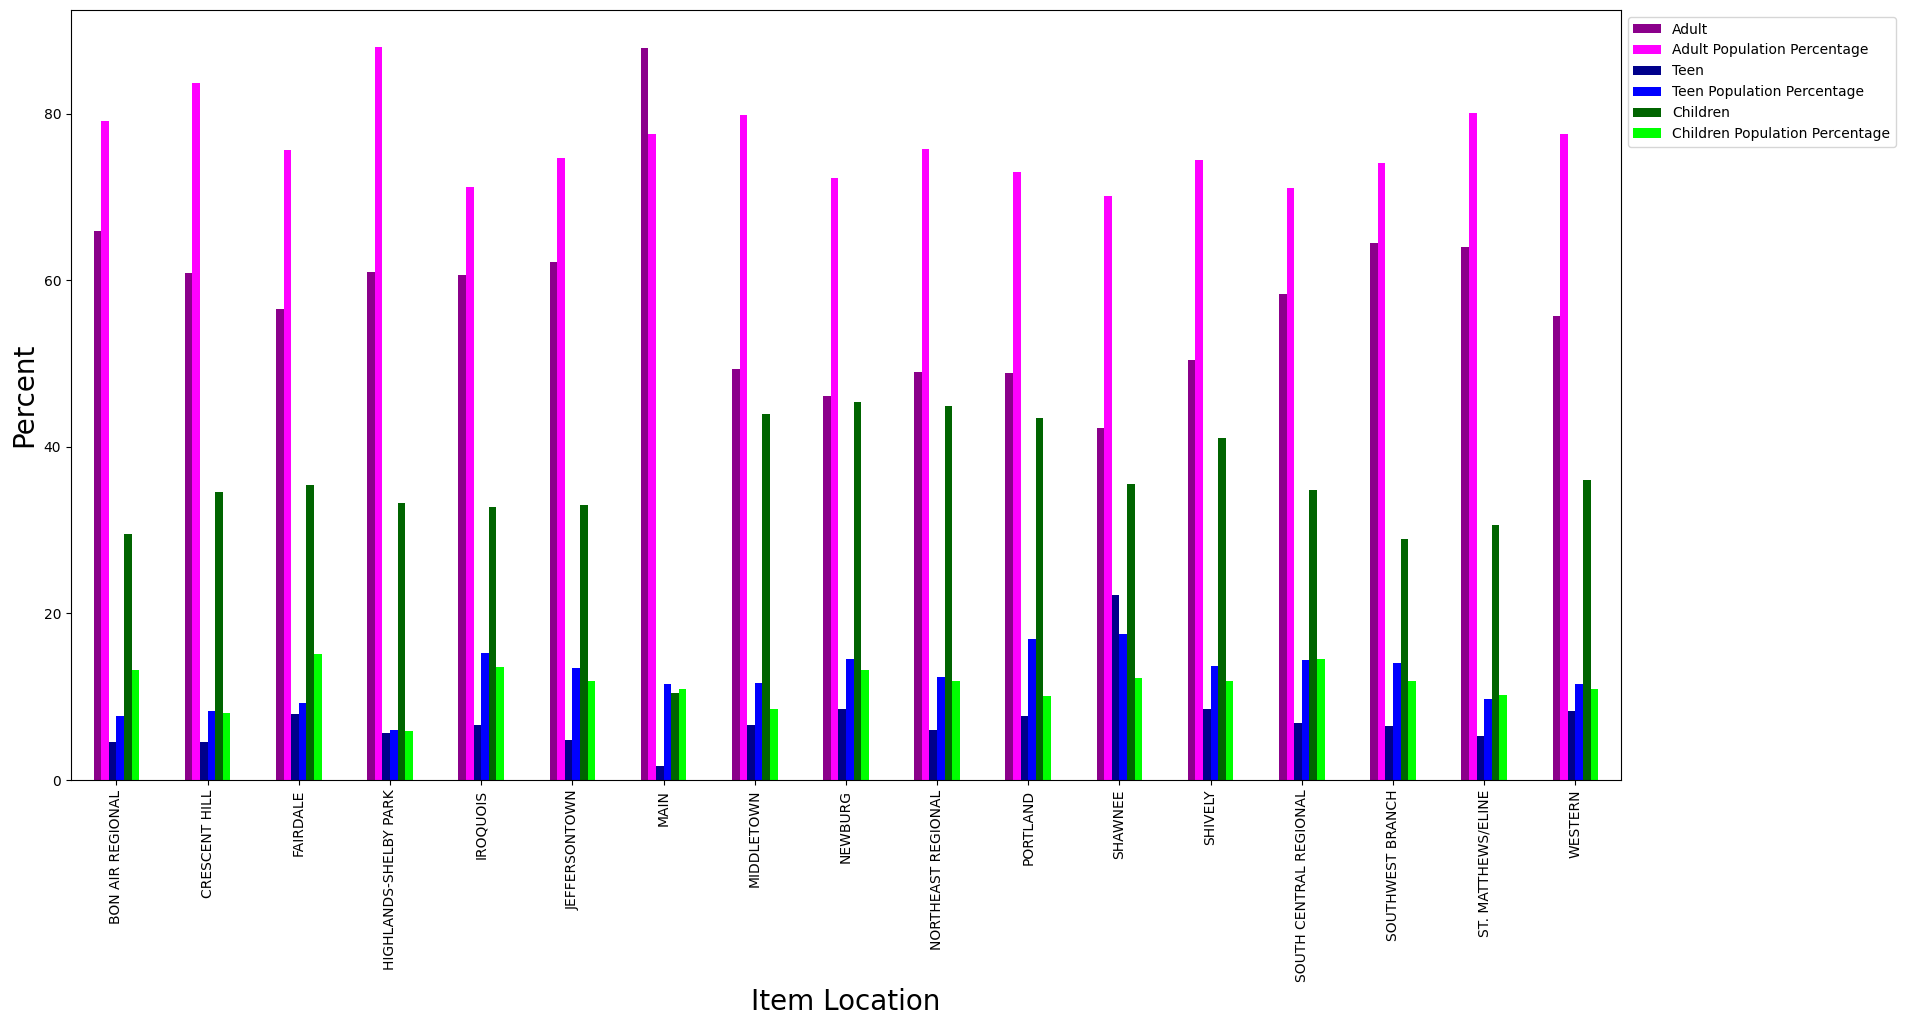

In [46]:
# basic visualization of the data from both datasets
# lighter color columns for population, darker for library collection
colors = ['darkmagenta', 'magenta', 'darkblue', 'blue', 'darkgreen', 'lime']
joined_reordered.plot(x='ItemLocation', kind="bar", color=colors, figsize=(20, 10))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Item Location', size = 20)
plt.ylabel('Percent', size = 20)
plt.show()

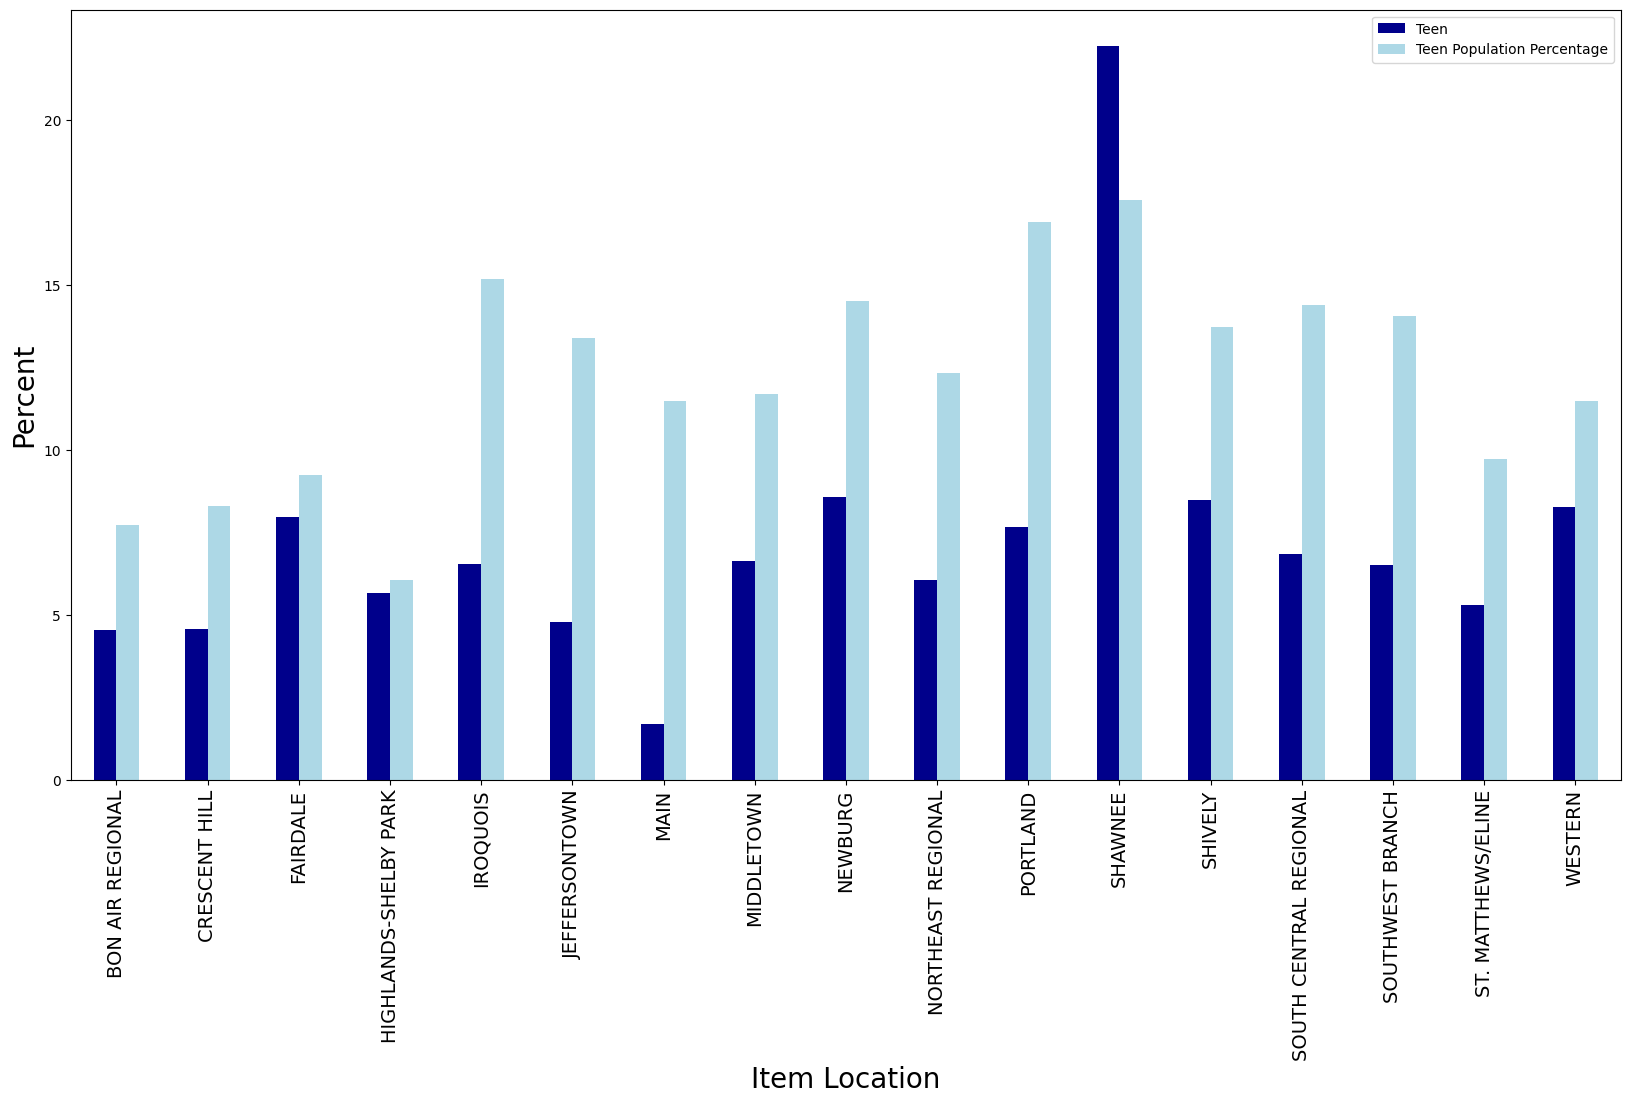

In [ ]:
# More detailed bar chart showing teen books and population only
colors = ['darkblue', 'lightblue']
joined_reordered[['Teen', 'Teen Population Percentage']].plot(kind="bar", color=colors, figsize=(20, 10))
plt.xticks(ticks=joined_reordered.index, labels=joined_reordered['ItemLocation'], size = 14)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Item Location', size = 20)
plt.ylabel('Percent', size = 20)
plt.show()


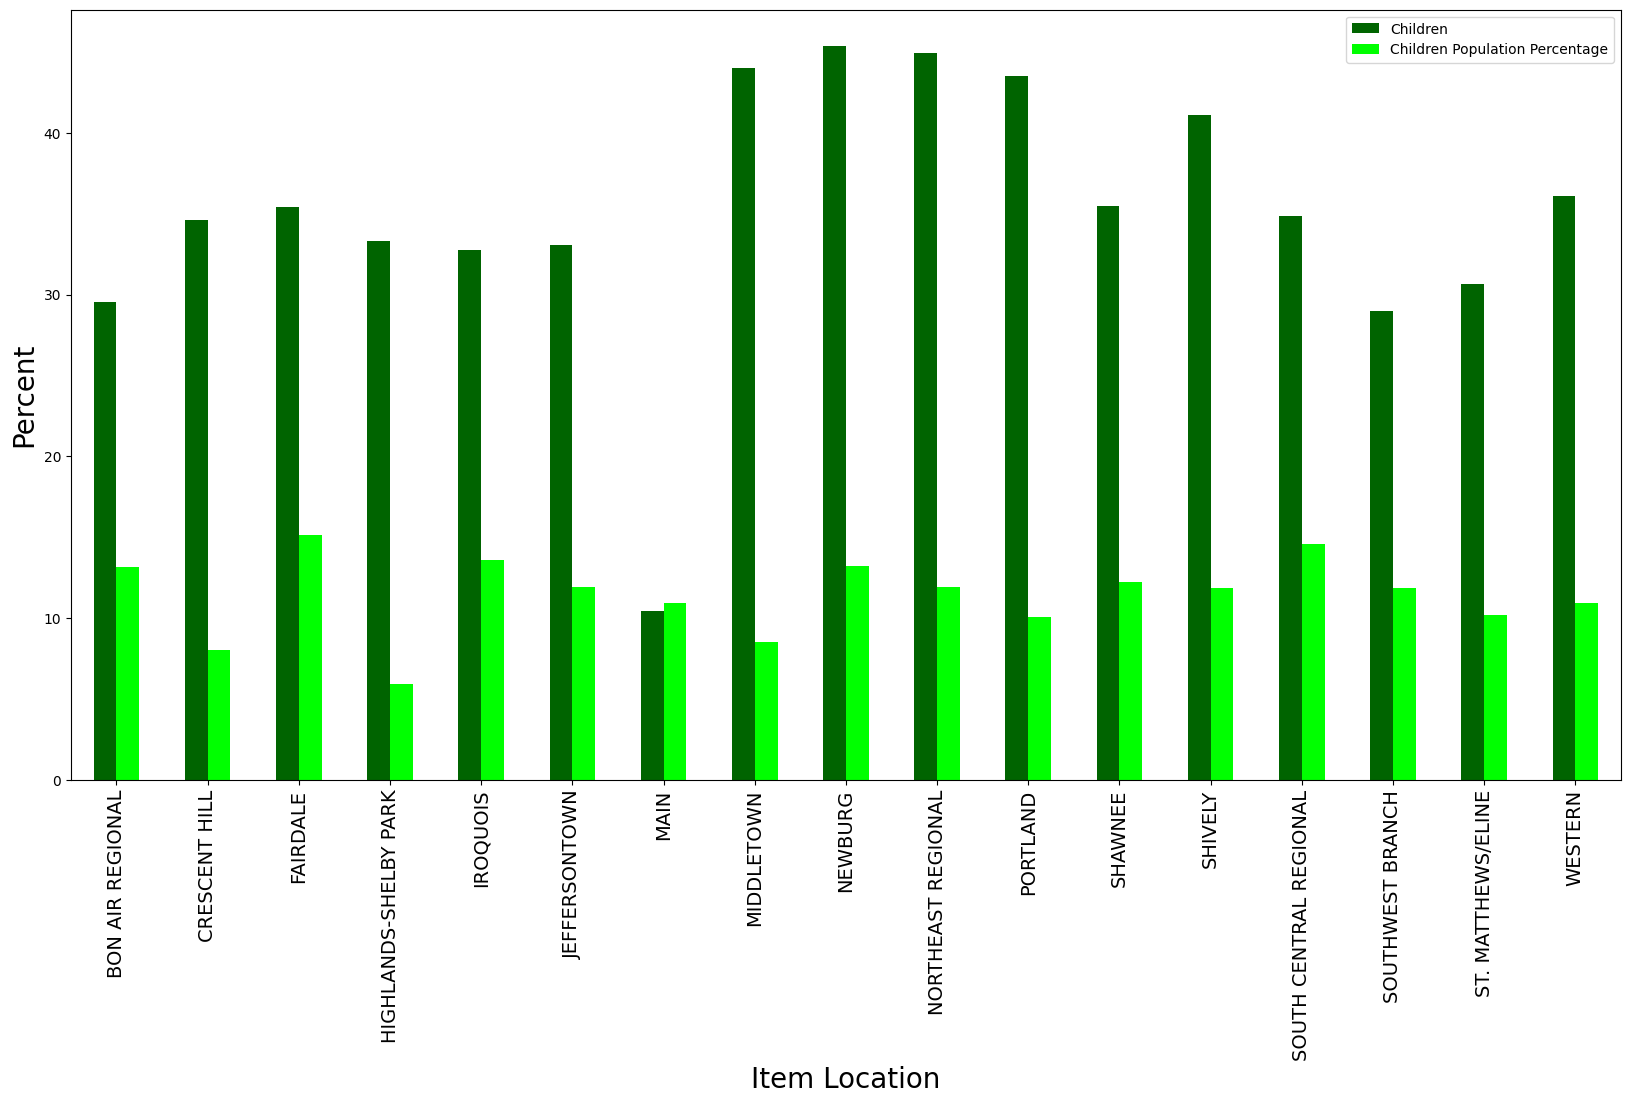

In [ ]:
# More detailed bar chart showing children books and population only
colors = ['darkgreen', 'lime']
joined_reordered[['Children', 'Children Population Percentage']].plot(kind="bar", color=colors, figsize=(20, 10))
plt.xticks(ticks=joined_reordered.index, labels=joined_reordered['ItemLocation'], size = 14)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel('Item Location', size = 20)
plt.ylabel('Percent', size = 20)
plt.show()

Interpreting the data

In general, the teen book collection is a much smaller percentage than the other books, this is true even in the areas with much larger teen demographics in the western and southern areas (cf. Portland, Iroquois, Shively, Southwest, South Central). This is the opposite of the children's collection (the percentage of children's books are significantly higher than the population at every branch except the Main branch).